In [8]:
from AssignGP import AssignGP

In [9]:
import GPflow
import tensorflow as tf
import numpy as np

In [10]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [11]:
#draw two samples
k = GPflow.kernels.Matern32(1, variance=4) + GPflow.kernels.White(1, variance=0.01)
x_free = tf.placeholder(tf.float64)
k.make_tf_array(x_free)

3

In [12]:
N = 50
D = 200
X = np.sort(np.random.rand(N,1),0)*5
with k.tf_mode():
    K = k.K(X)
    L = tf.cholesky(K)
L = tf.Session().run(L, feed_dict={x_free:k.get_free_state()})


In [13]:
X.shape

(50, 1)

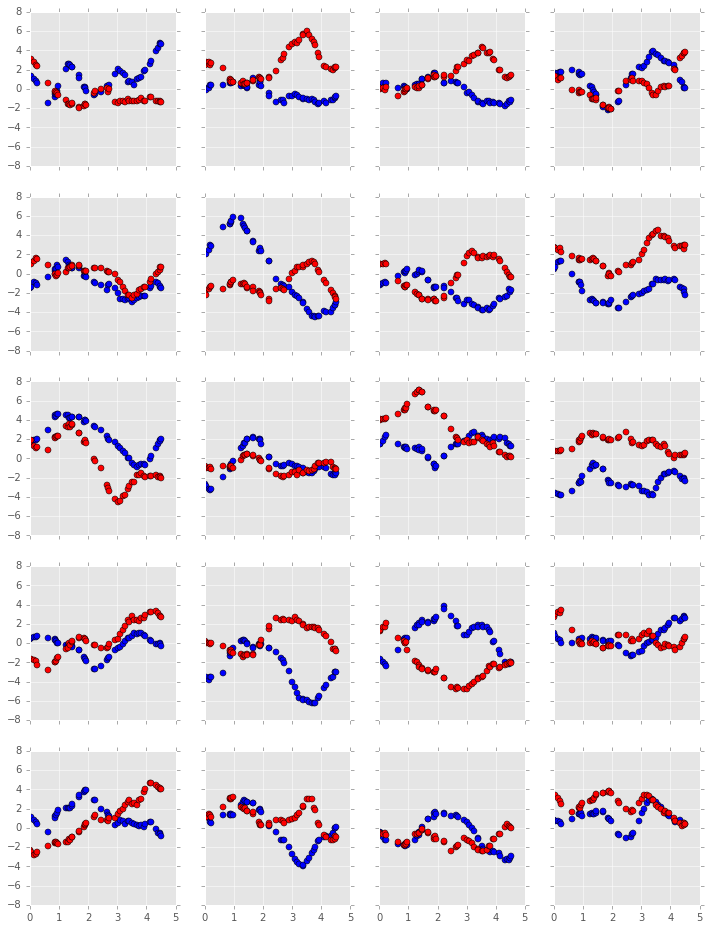

In [14]:

sample1 = np.dot(L, np.random.randn(N, D))
sample2 = np.dot(L, np.random.randn(N, D))
f, ax = plt.subplots(5,4,figsize=(12,16), sharex=True, sharey=True)

for d in range(20):
    ax.flatten()[d].plot(X, sample1[:,d], 'bo')
    ax.flatten()[d].plot(X, sample2[:,d], 'ro')


In [15]:
#make a new X that contains each time value twice,
# and with a corresponding 0 and 1 in the right-hand column

Xnew = np.vstack(( np.hstack([X.flatten()]*4), np.hstack((np.zeros(N*2), np.ones(N*2))))).T
Ynew = np.vstack((sample1, sample2))


In [16]:
inds = [[i, 2*N+i] for i in range(2*N)]

In [17]:
print inds

[[0, 100], [1, 101], [2, 102], [3, 103], [4, 104], [5, 105], [6, 106], [7, 107], [8, 108], [9, 109], [10, 110], [11, 111], [12, 112], [13, 113], [14, 114], [15, 115], [16, 116], [17, 117], [18, 118], [19, 119], [20, 120], [21, 121], [22, 122], [23, 123], [24, 124], [25, 125], [26, 126], [27, 127], [28, 128], [29, 129], [30, 130], [31, 131], [32, 132], [33, 133], [34, 134], [35, 135], [36, 136], [37, 137], [38, 138], [39, 139], [40, 140], [41, 141], [42, 142], [43, 143], [44, 144], [45, 145], [46, 146], [47, 147], [48, 148], [49, 149], [50, 150], [51, 151], [52, 152], [53, 153], [54, 154], [55, 155], [56, 156], [57, 157], [58, 158], [59, 159], [60, 160], [61, 161], [62, 162], [63, 163], [64, 164], [65, 165], [66, 166], [67, 167], [68, 168], [69, 169], [70, 170], [71, 171], [72, 172], [73, 173], [74, 174], [75, 175], [76, 176], [77, 177], [78, 178], [79, 179], [80, 180], [81, 181], [82, 182], [83, 183], [84, 184], [85, 185], [86, 186], [87, 187], [88, 188], [89, 189], [90, 190], [91, 191

In [104]:
m = AssignGP(Xnew, Ynew, IndKern(k), inds)

In [105]:
m.kern

Name,values,prior,constriant
kern.kern.k2.variance,[ 0.01],None,+ve
kern.kern.k1.lengthscales,[ 1.],None,+ve
kern.kern.k1.variance,[ 4.],None,+ve


In [106]:
m.likelihood

Name,values,prior,constriant
likelihood.variance,[ 1.],None,+ve


In [107]:
m.kern.kern.k1.variance = 4.
m.kern.kern.k1.variance.fixed = True
m.kern.kern.k1.lengthscales = 1.0
m.kern.kern.k1.lengthscales.fixed = True
m.kern.kern.k2.variance = 1e-6
m.kern.kern.k2.variance.fixed = True

m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True


m._compile()

compiling tensorflow function...
done


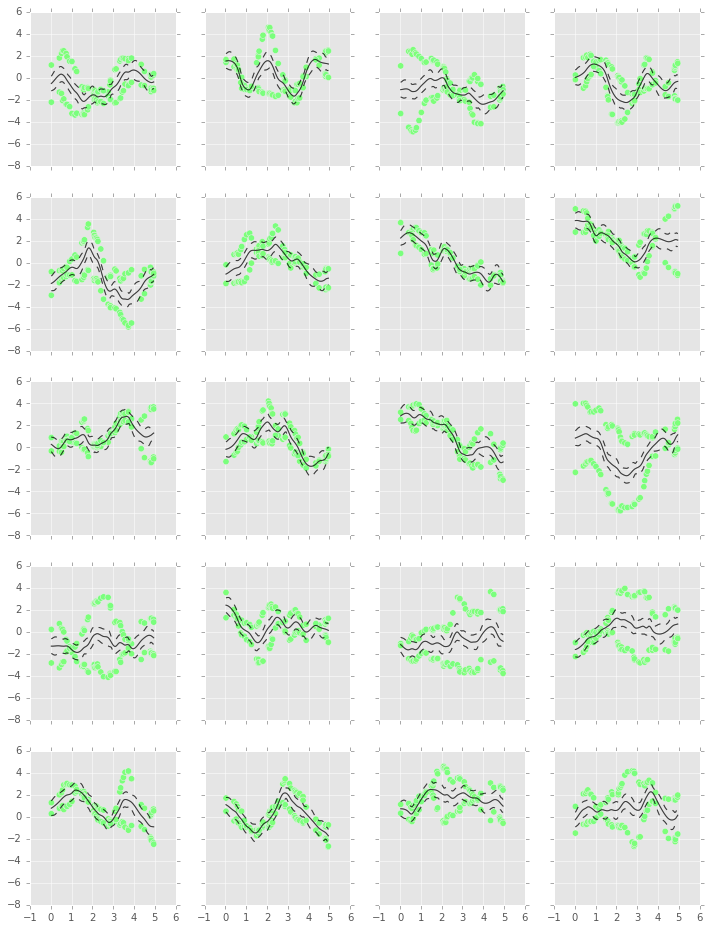

In [108]:

def plot():
    f, ax = plt.subplots(5,4,figsize=(12,16), sharex=True, sharey=True)
    with m.tf_mode():
        Phi = m.Phi.make_matrix()
    Phi = m._session.run(Phi, feed_dict={m._free_vars:m.get_free_state()})
    for d in range(20):
        ax.flatten()[d].scatter(m.X[:2*N,0], m.Y[:,d], 40, np.diag(Phi[:,:100]), vmin=0, vmax=1)
        #plt.colorbar()
    
    for ind in [0,1]:
        Xtest = np.vstack((np.linspace(m.X[:,0].min(), m.X[:,0].max(), 100), np.zeros(100) + ind)).T
        mu, var = m.predict_y(Xtest)
        for d in range(20):
            ax.flatten()[d].plot(Xtest[:,0], mu[:,d], 'k', alpha=0.5)
            ax.flatten()[d].plot(Xtest[:,0], mu[:,d] + 2*np.sqrt(var[:,0]), 'k--', alpha=0.5)
            ax.flatten()[d].plot(Xtest[:,0], mu[:,d] - 2*np.sqrt(var[:,0]), 'k--', alpha=0.5)

plot()

optimization terminated, setting model state
[-454641.16188059]
optimization terminated, setting model state
[-217075.28379559]
optimization terminated, setting model state
[-163956.06126406]


200

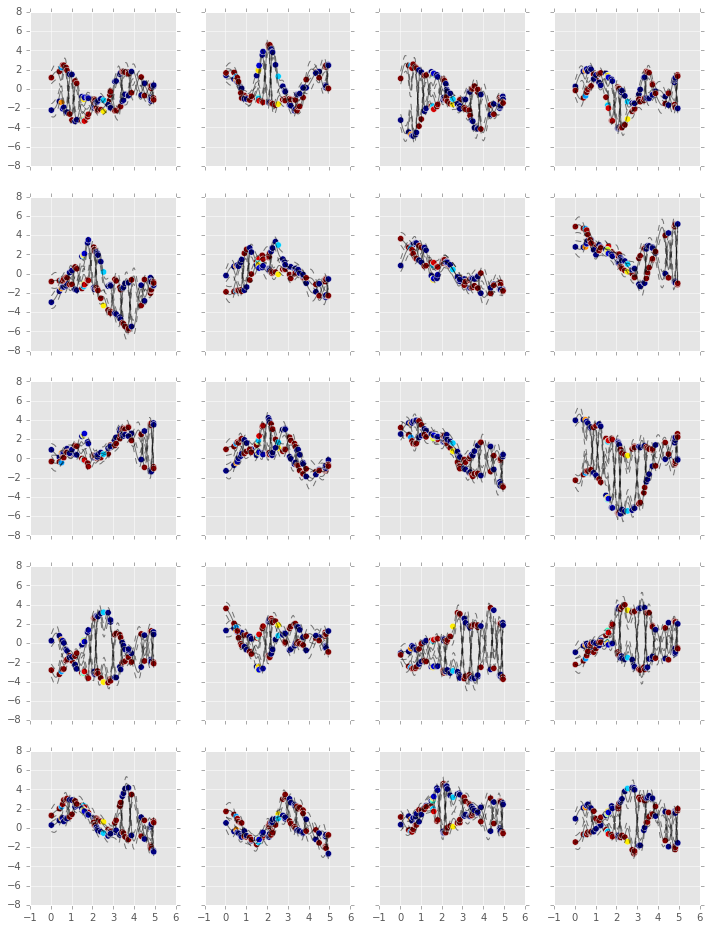

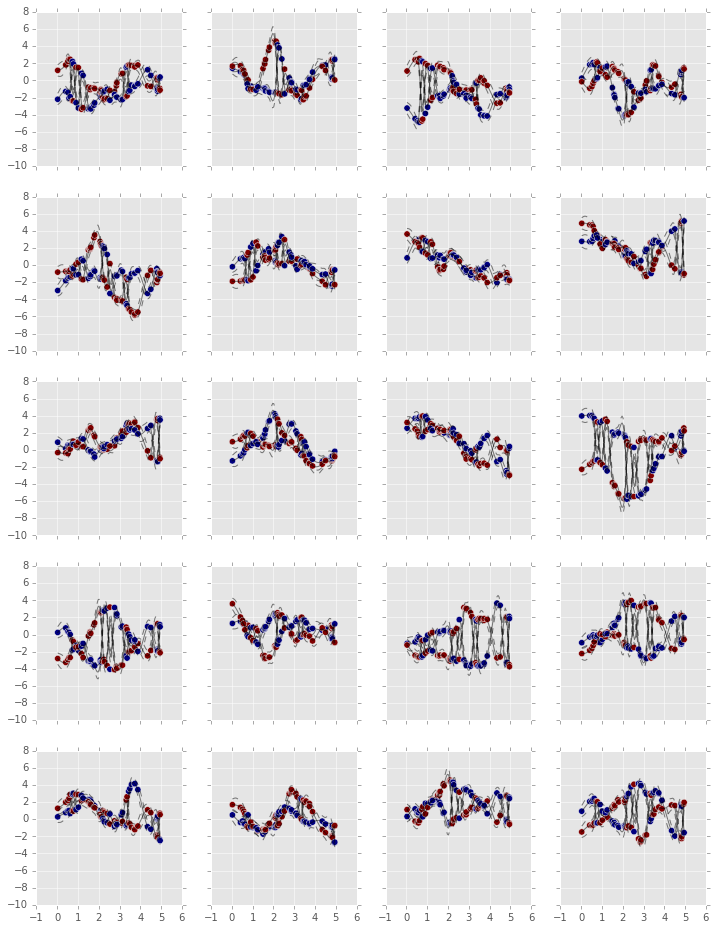

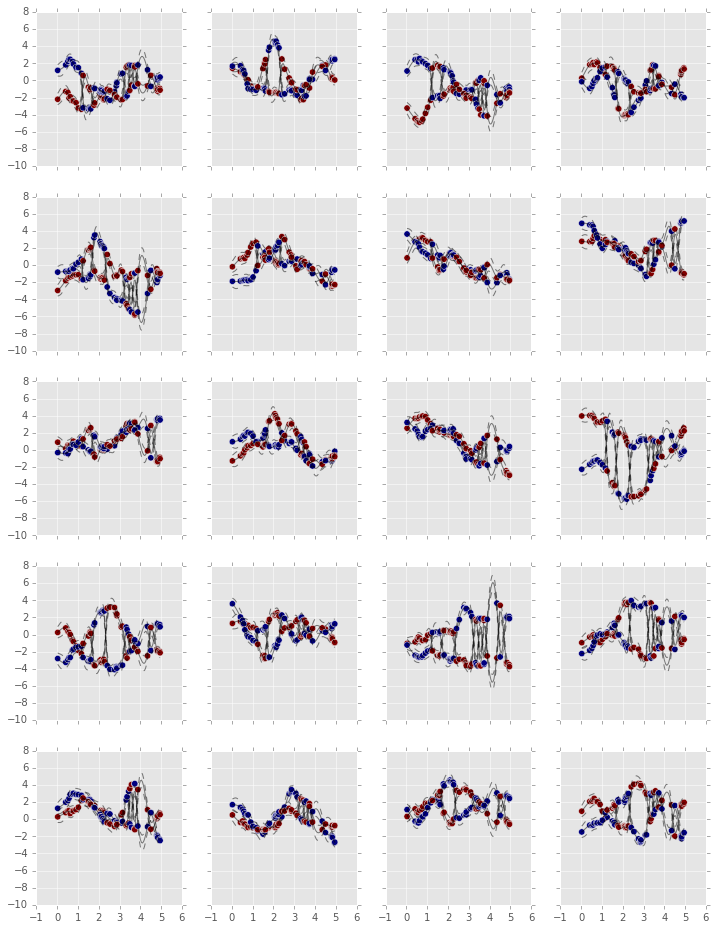

In [109]:
#do multiple restarts
solutions = []
likelihoods = []
for i in range(3):
    
    m.optimize()
    solutions.append(m.get_free_state())
    likelihoods.append(-m._objective(m.get_free_state())[0])
    plot()
    print likelihoods[-1]
    m.set_state(np.random.randn(m.get_free_state().size))
m.set_state(solutions[np.argmax(likelihoods)])

In [130]:
-m._objective(m.get_free_state())[0]

array([ 16610.19381792])

In [126]:
m.set_state(np.array([-1.,1.]*50 + [1., -1]*50))

200

In [127]:
-m._objective(m.get_free_state())[0]

array([-769728.89794241])

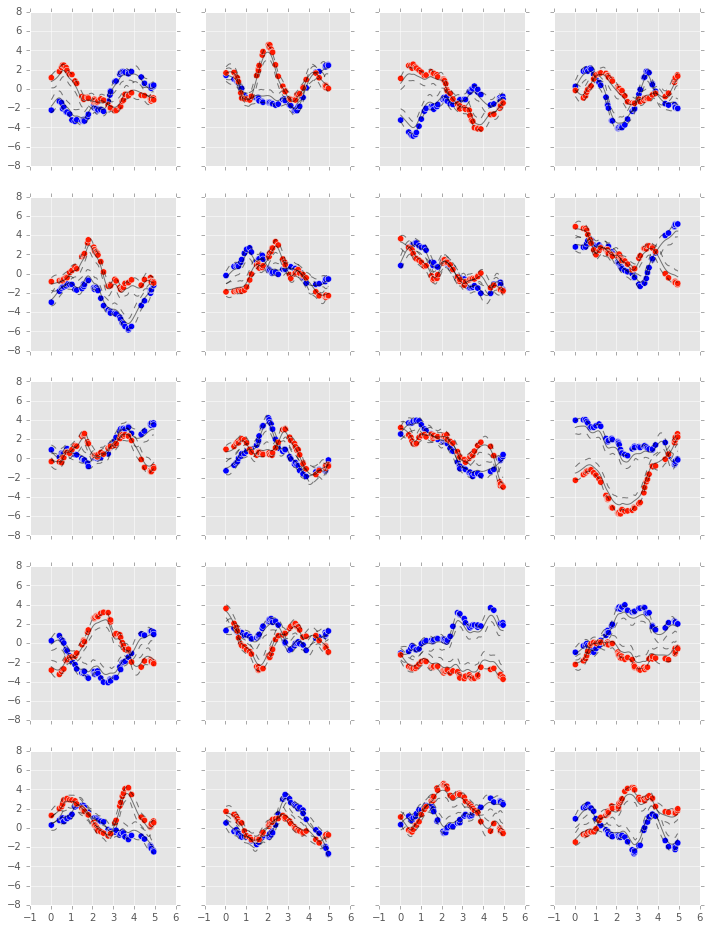

In [128]:
plot()

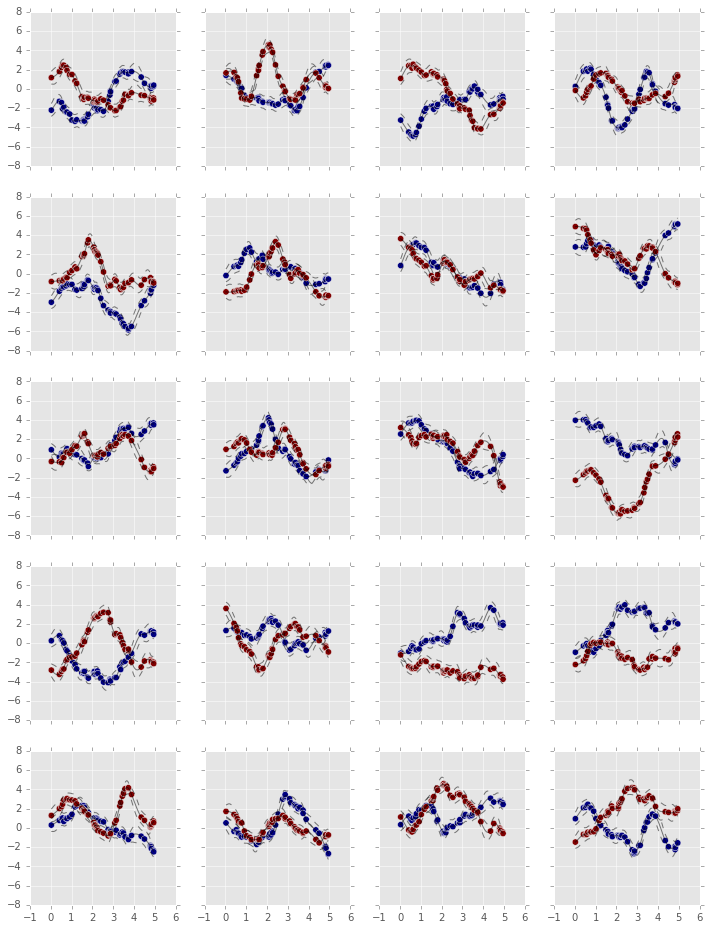

In [131]:
plot()

In [124]:
with m.tf_mode():
    Phi = m.Phi.make_matrix()
Phi = m._session.run(Phi, feed_dict={m._free_vars:m.get_free_state()})

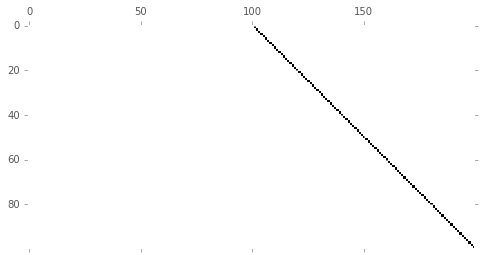

In [125]:
plt.matshow(Phi, cmap=plt.cm.binary)